# AC Pixel to Plate Transformation Workflow

**author:** Ciaran Breen

**date:** 28th August 2025

**Description:** This notebook outlines the workflow for transforming pixel coordinates from AC images to plate coordinates. The notebook describes the process from calibration measurements, maxtrox generation, and implementation of the transformations.

## Metrology Measurement

The first step in the workflow is to obtain accurate metrology measurements of the AC masks. A high resolution measurement of the plate is taken, with the AC masks in place, using the AC-MEASUREMENT Hexagon configuration either primary or backup camera. This measurement will return a set of XYZ coordinates for each target on the plate, either white targets on a black background or black targets on a white background. These measurements should be aligned to the plate coordinate system, but not filtered. Filtering by target size as implemented in the typical FPU measurement will remove the AC targets as they are not the same size as the FPU targets. 

 ### Metrology Measurement of AC Masks


In [1]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from src.metro_io import read_metro_raw

# make the font more readable
mpl.rcParams.update({
    "font.size": 14})

The AC masks are small circular masks ~ 13mm in diameter which are placed at the end of tubes fitted to the ACs. The masks should be mounted at the focal plane of the instrument. In this measurement 6 masks are fitted to the plate. However, 3 masks were found to sit a few millimeters too high and had to be removed and machined to a lower height.

Masks 1, 8, and 13 (according to SW's facet coordinate spreadsheet) are at the correct height and can be used for analysis purpose in the=is notebook.

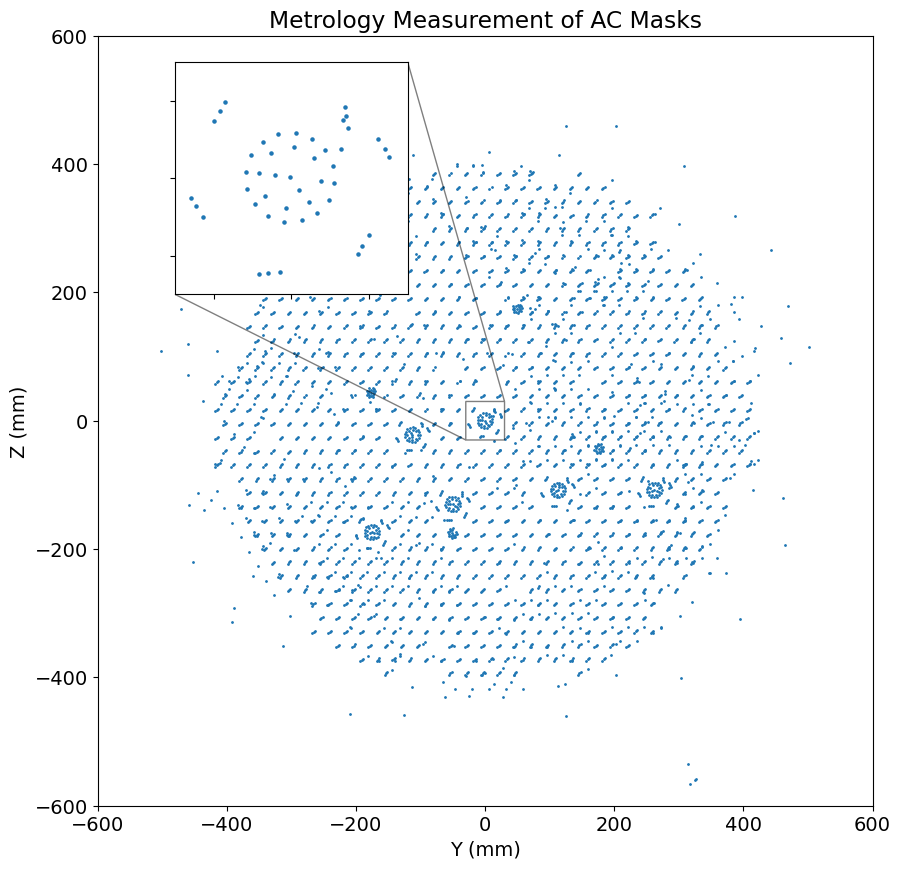

In [62]:
# load the metrology raw file
mfn = "../test_data/PAE-AC-TESTS_JUL2024/METRO_OUT.txt"
mdata = read_metro_raw(mfn)

# display the data with a cut out of an indiviudal AC
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(mdata['Y'], mdata['Z'], s=1)
ax.set_xlabel('Y (mm)')
ax.set_ylabel('Z (mm)')
ax.set_xlim(-600, 600)
ax.set_ylim(-600, 600)
# inset Axes....
x1, x2, y1, y2 = -30, 30, -30, 30  # subregion of the original image
axins = ax.inset_axes(
    [0.1, 0.6, 0.3, 0.43],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.scatter(mdata["Y"], mdata["Z"], s=5)
axins.set_aspect('equal')
indax = ax.indicate_inset_zoom(axins, lw=1, edgecolor='k')
indax.connectors[3].set_visible(True)
indax.connectors[0].set_visible(True)
ax.set_title('Metrology Measurement of AC Masks')
plt.show()

### Align the dataset

In this notebook I use the raw output of the metrology system. This dataset is unfiltered and unaligned. The dataset MUST be aligned to the reference coordinate system before calculating the transformation matrices. Otherwise, there will be significant error (up to 500 microns) in the transformations.

I recommend using the aligned but unfiltered output of the metrology in future. The aligned and filtered output may also be used. However, depending on the filtering paramters, the filtering process may reomve real mask points. In this case, I apply alignment and filtering manually. The filtering step removes the masks which need their height modified as they are not at the focal plane of the instrument.

In the case that the aligned metrology output is used, this step may be skipped.

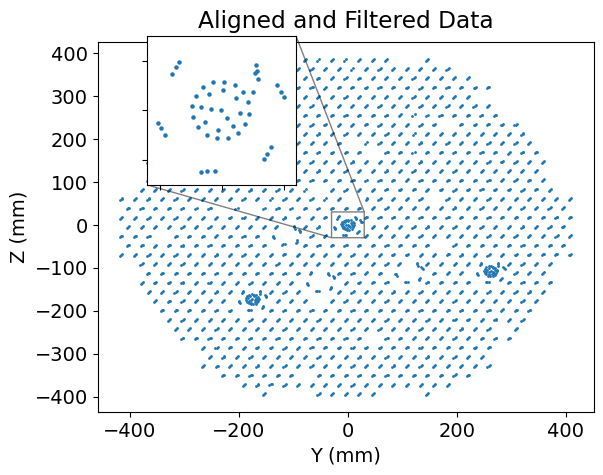

In [63]:
from src.preprocessing import preprocess_pntcld

# reference point cloud
ref_fn = "../test_data/reference_190325/processed/REFERENCE_CODED_TARGETS_190325.txt"
ref_data = np.loadtxt(ref_fn)

# align and filter the data
amdata = preprocess_pntcld(mfn, ref_fn)

fig, ax = plt.subplots()
ax.scatter(amdata[:,2], amdata[:,3], s=1)
# inset Axes....
x1, x2, y1, y2 = -30, 30, -30, 30  # subregion of the original image
axins = ax.inset_axes(
    [0.1, 0.6, 0.3, 0.43],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.scatter(mdata["Y"], mdata["Z"], s=5)
axins.set_aspect('equal')
indax = ax.indicate_inset_zoom(axins, lw=1, edgecolor='k')
indax.connectors[3].set_visible(True)
indax.connectors[0].set_visible(True)
ax.set_xlabel("Y (mm)")
ax.set_ylabel("Z (mm)")
ax.set_title("Aligned and Filtered Data")
plt.show()


### Extract ACs

The ACs must now be individually extracted from the measurement. This is done using an estimate of their position from the facet coordinate spreadsheet. The estimated positions are then used to crop the point cloud data to the region of interest for each AC.

The points are cropped using the estimated positions and a fixed radius to create a cylindrical volume around each AC. This cylindrical volume is then used to extract the points corresponding to each AC from the point cloud data.

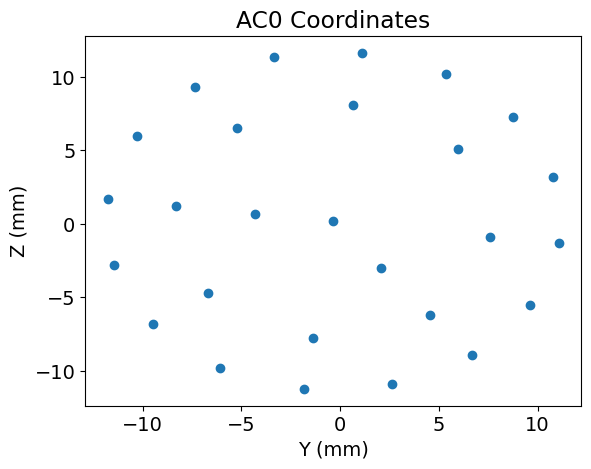

In [64]:
def filter_points_in_cylinder(points, cylinder_axis_start, cylinder_axis_end, radius):
    """
    Filters a 3D point cloud to retain only points inside a cylinder.

    Parameters:
    - points: (N, 3) numpy array of 3D points.
    - cylinder_axis_start: (3,) array-like, start point of the cylinder axis.
    - cylinder_axis_end: (3,) array-like, end point of the cylinder axis.
    - radius: float, radius of the cylinder.

    Returns:
    - filtered_points: (M, 3) numpy array of points inside the cylinder.
    """
    # Convert inputs to numpy arrays
    p0 = np.array(cylinder_axis_start)
    p1 = np.array(cylinder_axis_end)
    v = p1 - p0  # Cylinder axis vector
    v_length = np.linalg.norm(v)
    v_unit = v / v_length

    filtered_points = []

    for point in points:
        # Vector from p0 to the point
        w = point - p0
        # Project w onto the cylinder axis
        projection_length = np.dot(w, v_unit)
        
        # Check if the projection falls within the cylinder height
        if 0 <= projection_length <= v_length:
            # Compute the perpendicular distance from the point to the axis
            closest_point_on_axis = p0 + projection_length * v_unit
            distance_to_axis = np.linalg.norm(point - closest_point_on_axis)
            
            if distance_to_axis <= radius:
                filtered_points.append(point)

    return np.array(filtered_points)


# demonstrate the filtering for the central mask at (0,0,0)
ac0_coords = filter_points_in_cylinder(amdata[:,1:4], [-5,0,0], [5,0,0], 13)


fig, ax = plt.subplots()
ax.scatter(ac0_coords[:,1], ac0_coords[:,2])
ax.set_xlabel("Y (mm)")
ax.set_ylabel("Z (mm)")
ax.set_title("AC0 Coordinates")
plt.show()

With the function `filter_points_in_cylinder`, we can easily extract the coordinates of the points within the specified cylindrical region. We now need to apply this function to each of the ACs to obtain their respective masks.

The mask centres will estimated from their location as specified in the AC_nominal_positions.csv spreadsheet which is adapted from the facet coordinate spreadsheet. This means we will use the nominal positions of the ACs to define the cylindrical regions for filtering the point cloud data.

The nominal positions are shown below

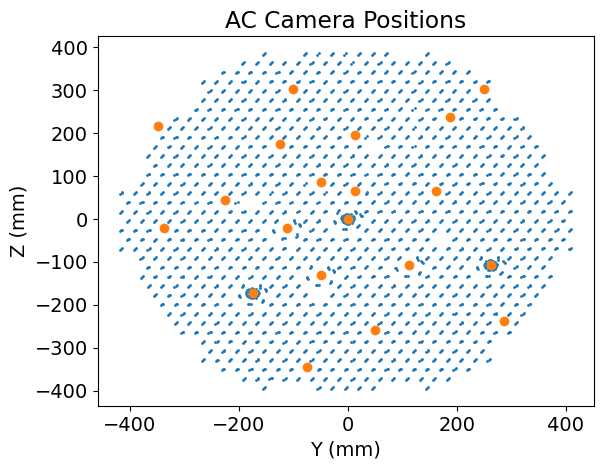

In [ ]:
import pandas as pd
# get the nominal positions of the AC cameras
mask_pos_fn = "../testing_data/AC_nominal_positions.csv"
mask_pos = pd.read_csv(mask_pos_fn)


fig, ax = plt.subplots()
ax.scatter(amdata[:,2], amdata[:,3], s=1)
ax.scatter(mask_pos["Y"], mask_pos["Z"])
ax.set_xlabel("Y (mm)")
ax.set_ylabel("Z (mm)")
ax.set_title("AC Camera Positions")
plt.show()



A function can now be defined which takes the nominal positions spreadsheet and the point cloud data to extract the masks for each AC. This gives us the location of all of the individual AC masks as measured by the metrology system.


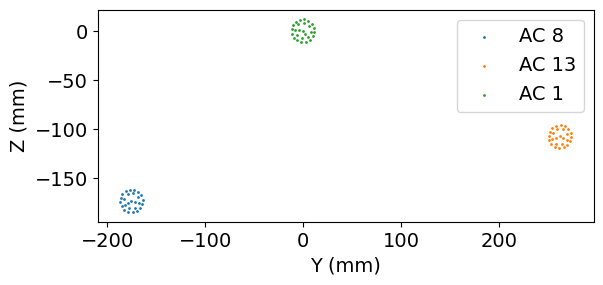

In [6]:
def get_AC_masks(data, ids, coords, rad=13, htol=5):
    """Extracts masks for ACs from the point cloud data."""

    # Initialize output dictionary
    out_dict = {}

    # Loop through each AC and extract its mask
    for row in range(len(coords)):
        # get the mask center and ID
        mask_cntr = coords[row]
        mask_id = ids[row]

        # Define the cylinder axis with height tolerance
        start_axis = [mask_cntr[0]-htol, mask_cntr[1], mask_cntr[2]]
        end_axis = [mask_cntr[0]+htol, mask_cntr[1], mask_cntr[2]]
        # get the mask coordinates
        mask_coords = filter_points_in_cylinder(data, start_axis, end_axis, 
                                                radius=rad)
        # append the mask coordinates to the output dictionary
        out_dict[mask_id] = mask_coords
    
    return out_dict

# Keep only the relevant ACs
keep_list = [1, 8, 13]
kp_mask_pos = mask_pos[mask_pos["AC ID"].isin(keep_list)]

# Get the AC masks
AC_masks = get_AC_masks(amdata[:,1:4], kp_mask_pos["AC ID"].to_numpy(),
                        kp_mask_pos[["X", "Y", "Z"]].to_numpy())


# plot the masks
fig, ax = plt.subplots()
for id in AC_masks:
    ax.scatter(AC_masks[id][:,1], AC_masks[id][:,2], s=1, label=f"AC {id}")
ax.set_xlabel("Y (mm)")
ax.set_ylabel("Z (mm)")
ax.set_aspect("equal")
plt.legend()
plt.show()


## AC image of mask

With the metrology measurements of masks obtained from the point cloud data, the next step is to measure the masks from the AC itself. This is done by taking an image with the AC with the mask still fitted. The image is then processed to find the centroid (and size) of each of the mask points. The result of this centroid process is shown below for AC0. It should be noted that the AC component ID (from facet coordinate spreadsheet) doesn’t match with the AC ID in the ICS. 

The mapping between the two sets of IDs should be supplied by Steve Watson.

For the purposes of this demonstration, I use the known mapping of AC1 (facet coordinate spreadsheet) = AC6 (ICS).

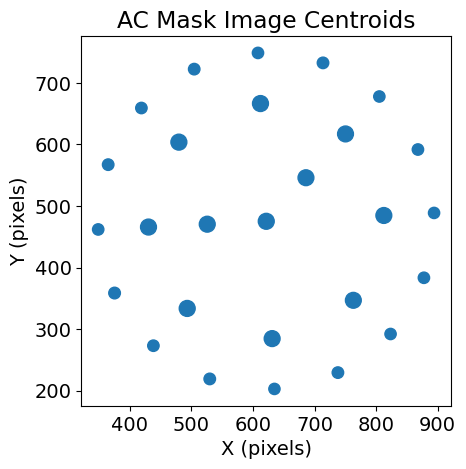

In [7]:
# load the AC mask file (ACQ6 ICS = AC1 Facet coordinate spreadsheet)
acfn = "../data/PAE/PAE_04_08/PAE_04_08_01/PAE_04_08_01_ACIM/MOONS2_TCCDACQ18_2024-06-28T09_40_15.txt"
ac_data = np.loadtxt(acfn)

fig, ax = plt.subplots()
ax.scatter(ac_data[:,0], ac_data[:,1], s=ac_data[:,2]*2)
ax.set_xlabel("X (pixels)")
ax.set_ylabel("Y (pixels)")
ax.set_aspect('equal')
ax.set_title("AC Mask Image Centroids")
plt.show()

## Match Points

We now have two sets of mask points: one from the metrology point cloud data and one from the AC image. The next step is to match these two sets of points to obtain a correspondence between the metrology measurements and the AC image centroids. I implement this matching by manually inspecting the plots and identifying two sets of corresponding points. Usually, the centre point and an adjacent point.

The identification of these corresponding points is shown in the following figure.

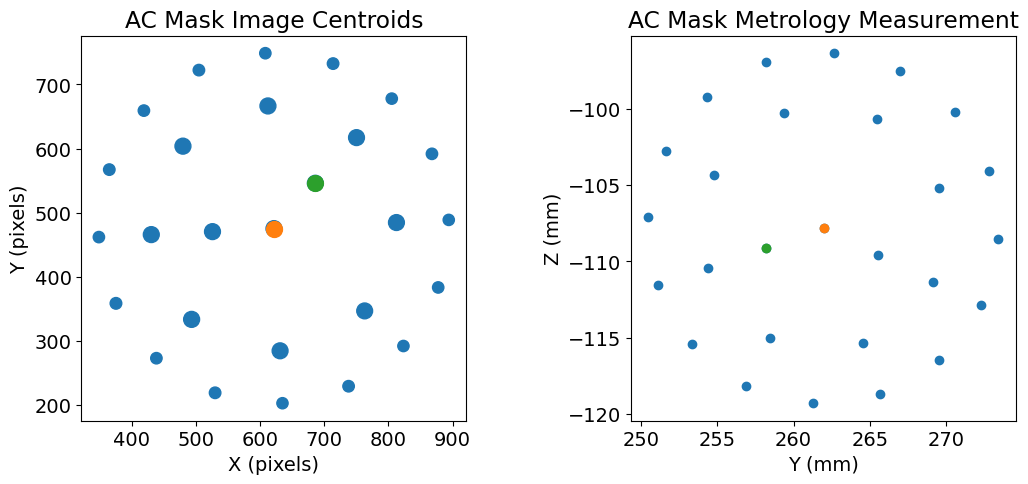

In [14]:
# load AC mask 1 from the metrology
metmask1 = AC_masks[13]

# identify the indices of the corresponding points for:
# centre
met_cntr_idx = 12
cam_cntr_idx = 14
# and adjacent point
met_p1_idx = 7
cam_p1_idx = 10

# plot the corresponding points
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].scatter(ac_data[:,0], ac_data[:,1], s=ac_data[:,2]*2)
ax[0].scatter(ac_data[cam_cntr_idx,0], ac_data[cam_cntr_idx,1], s=ac_data[cam_cntr_idx,2]*2)
ax[0].scatter(ac_data[cam_p1_idx,0], ac_data[cam_p1_idx,1], s=ac_data[cam_p1_idx,2]*2)
ax[0].set_xlabel("X (pixels)")
ax[0].set_ylabel("Y (pixels)")
ax[0].set_aspect('equal')
ax[0].set_title("AC Mask Image Centroids")
ax[1].scatter(metmask1[:,1], metmask1[:,2])
ax[1].scatter(metmask1[met_cntr_idx,1], metmask1[met_cntr_idx,2])
ax[1].scatter(metmask1[met_p1_idx,1], metmask1[met_p1_idx,2])
ax[1].set_xlabel("Y (mm)")
ax[1].set_ylabel("Z (mm)")
ax[1].set_aspect('equal')
ax[1].set_title("AC Mask Metrology Measurement")
plt.show()

A rough alignment using these two points can be achieved by changing to a basis where the the two points are aligned and the two mask datasets are in the same plane. A nearest neighbor search can be used to find the corresponding points in the two datasets. This is implemented in the get_corr module.

The two masks with correspondances labelled are shown below.

Note: to transform between pixel coordinates in 2D and plate coordinates in 3D, you need to add a third dimension to the 2D points. This can be done by setting the Z coordinate to zero for all points in the AC image. This assumes that the AC mask can be approximated as being a flat plane parallel to the AC camera itself.

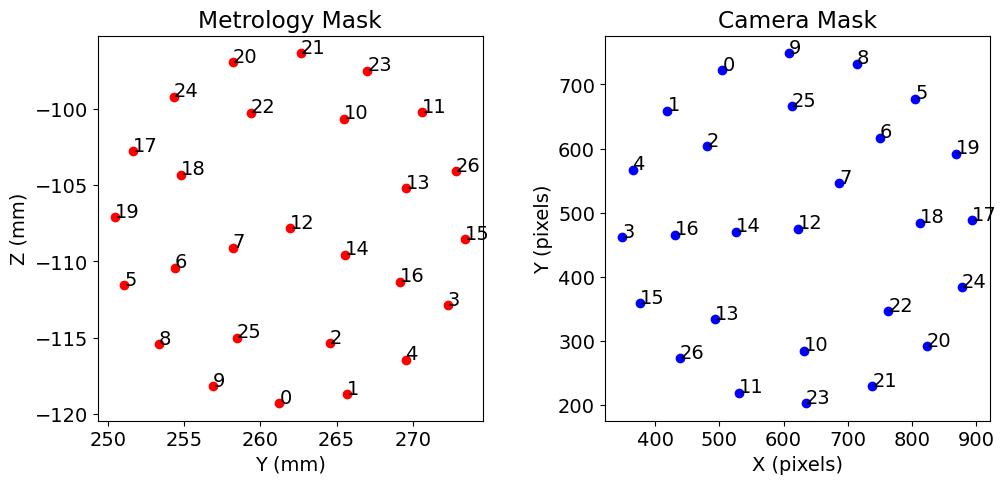

In [15]:
from src.get_corr import get_corr

# pad the AC file to add the dummy depth dimension
ac3d = np.hstack((np.zeros((len(ac_data[:, 1]), 1)), ac_data[:,0:2]))

# get correspondences
idx_met, idx_ac = get_corr(metmask1, ac3d, (met_cntr_idx, met_p1_idx), 
                           (cam_cntr_idx, cam_p1_idx))

# sort the datasets so the correspondences are aligned
corr_ac = ac3d[idx_ac]
corr_met = metmask1[idx_met]

# plot the correspondences
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(corr_met[:,1], corr_met[:,2], c='r')
ax[0].set_title('Metrology Mask')
ax[0].set_xlabel("Y (mm)")
ax[0].set_ylabel("Z (mm)")
ax[0].set_aspect('equal')
ax[1].scatter(corr_ac[:,1], corr_ac[:,2], c='b')
ax[1].set_title('Camera Mask')
ax[1].set_xlabel("X (pixels)")
ax[1].set_ylabel("Y (pixels)")
ax[1].set_aspect('equal')
for i in range(len(corr_met)):
    ax[0].text(corr_met[i,1], corr_met[i,2], str(i))
    ax[1].text(corr_ac[i,1], corr_ac[i,2], str(i))
plt.show()

## Create the Transfomation Matrices

We now have:

1. A measurement of the AC mask in plate coordinates taken by the metrology system
2. A measurement of the metrology mask in pixel coordinates taken by the AC camera
3. A set of correspondences between the two masks

With these three elements, we can now proceed to align the two masks and generate a transformation matrix that maps pixel coordinates to plate coordinates. This transformation matrices is generated using the Kabsch-Umeyama algorithm (see # see https://web.stanford.edu/class/cs273/refs/umeyama.pdf). The matrix is a 4x4 augmented transformation matrix which describes a rigid body transformation with uniform scaling and a translation. A more detailed description of the transformation process can be found in my handover document.

An implementation of the Kabsch-Umeyama algorithm can be found in the align module.

In [16]:
from src.align import kabsch_umeyama

# align the two masks and generate the transformation matrix
tmat = kabsch_umeyama(corr_met, corr_ac)

print("Transformation Matrix (Plate to Pixel):")
print(tmat)

Transformation Matrix (Plate to Pixel):
[[ 4.20059354e-02  2.91559611e-03  2.76886926e-04 -1.17066412e+01]
 [ 2.68717996e-03 -3.67859168e-02 -2.03138221e-02  2.94484465e+02]
 [-1.16465915e-03  2.02822977e-02 -3.68828950e-02 -1.02886885e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Example Usage

The remainder of the notebook will demonstrate how this transformation matrix was used to transform pixel coordinates to plate coordinates and move an FPU to a source on the in the AC.

This example is taken from testing done during MOONS PAE on 01/07/2024. A source was mounted in front of the plate and aligned with AC13 (ICS: AC18). An image was taken with the AC camera and the source centroid estimated by eye. This centroid was then transformed to the plate coordinate system using the transformation matrix. With this transformation, the position of the source can be accurately determined in the plate coordinates, allowing an FPU to be moved to the correct position.

The following function is used to convert from plate cartesian coordinates to plate polar coordinates. It accounts for the curvature of the plate.


In [46]:
def convert_to_polar(Yfiber, Zfiber, roc=4101.1):
    # convert to polar coordinates, it assumes origin (0,0)
    flat_R = np.sqrt(Yfiber**2 + Zfiber**2)
    theta = np.pi/2 - np.arctan2(Zfiber,Yfiber)
    # use positive angles MOONS-1410
    theta = (theta + 2 * np.pi) % (2 * np.pi)

    # convert radial distance into the radial distance 
    # projected onto a curved focal plane
    ratio = abs(flat_R / roc)
    curved_R = roc * np.arcsin(ratio)
    
    return curved_R, theta

The function pix2plt is used to implement the transformation from pixel coordinates to plate coordinates. It takes X, Y pixel coordinates and applies a transformation matrix to obtain the corresponding plate coordinates (X, Y, Z).

For a given source position in pixel coordinates, the function will return the corresponding position in plate coordinates. As a check, the centroid positions of the mask as measured by the AC can be transformed into plate coordinates and compared with the metrology measurements.


In [59]:
from src.transform.acq_cam import pix2plt

# define the source position (estimated by eye)
source_pos = np.expand_dims(np.array([751, 422]), axis=0)

# do the transformation
pix_in_plate = pix2plt(corr_ac[:,1:3], tmat)
source_in_plate = pix2plt(source_pos, tmat)

diff = pix_in_plate - corr_met
print(f"RMS Difference Between AC image and Metrology Measurement (Plate Cartesian Coordinates) [X, Y, Z] = {np.sqrt(np.mean(diff**2, axis=0))} mm")

# convert to polar coordinates
R_source, theta_source = convert_to_polar(source_in_plate[0][1], source_in_plate[0][2])

print(f"Source Position (Plate Cartesian Coordinates) [X, Y, Z] = {source_in_plate[0]}")
print(f"Source Position (Plate Polar Coordinates) [R, Theta] = [{R_source:.4f} mm, {np.degrees(theta_source):.4f} deg]")

RMS Difference Between AC image and Metrology Measurement (Plate Cartesian Coordinates) [X, Y, Z] = [0.02042815 0.03223645 0.02486277] mm
Source Position (Plate Cartesian Coordinates) [X, Y, Z] = [  -9.4001822   258.28580893 -103.21946135]
Source Position (Plate Polar Coordinates) [R, Theta] = [278.3608 mm, 111.7833 deg]


The following plots visualise the transformation from pixel coordinates to plate coordinates, and show the source position in each of the coordinate systems.

The first plot shows the data in pixel coordinates, with the source position marked. The second plot shows the data in plate Cartesian coordinates, with the source position transformed into this coordinate system. The third plot zooms in on the mask region in plate Cartesian coordinates and also shows the AC mask centroids transformed into this coordinate system. The error in the transformation can be seen in the differences between the original and transformed positions of the mask centroids. The final plot shows the data in plate polar coordinates, with the source position also transformed into this coordinate system.


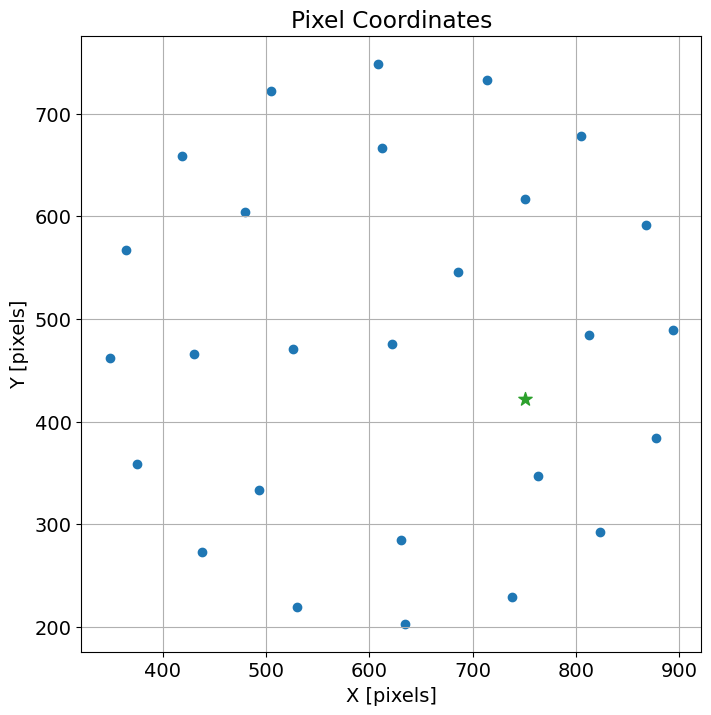

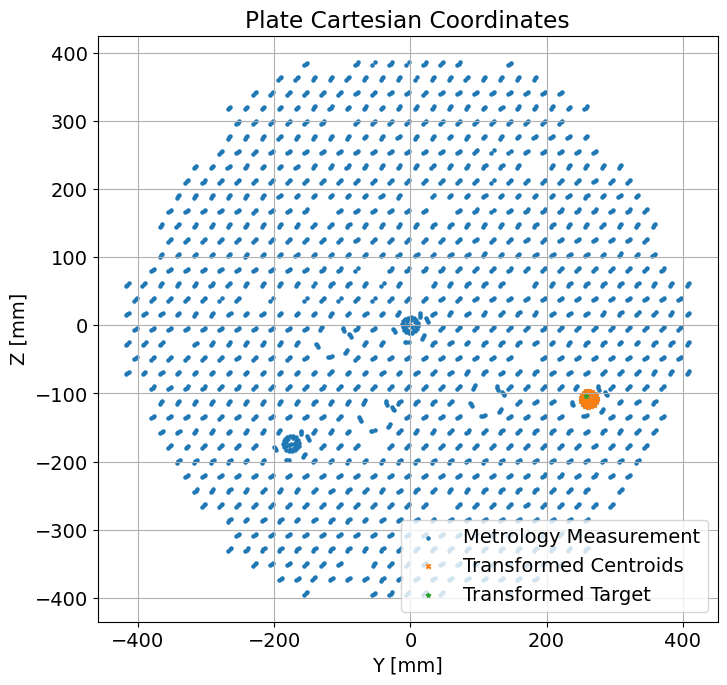

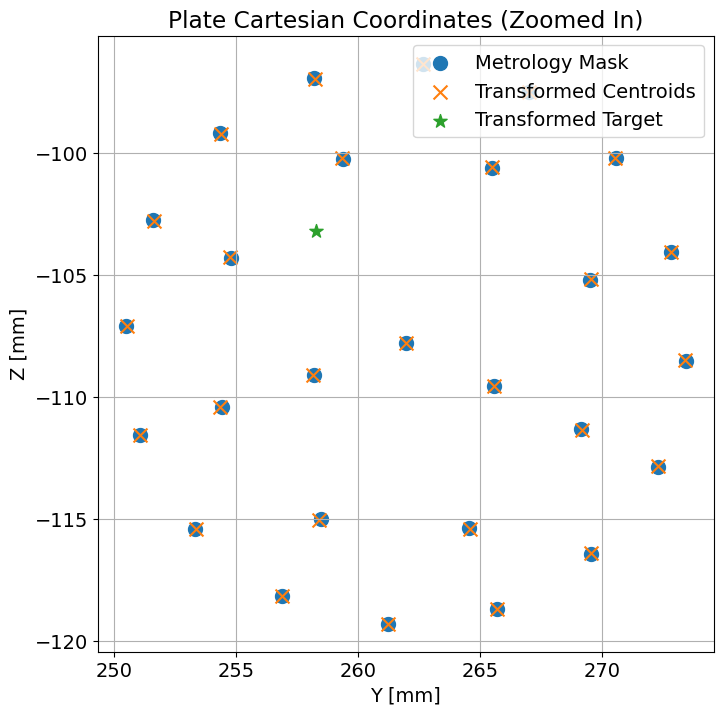

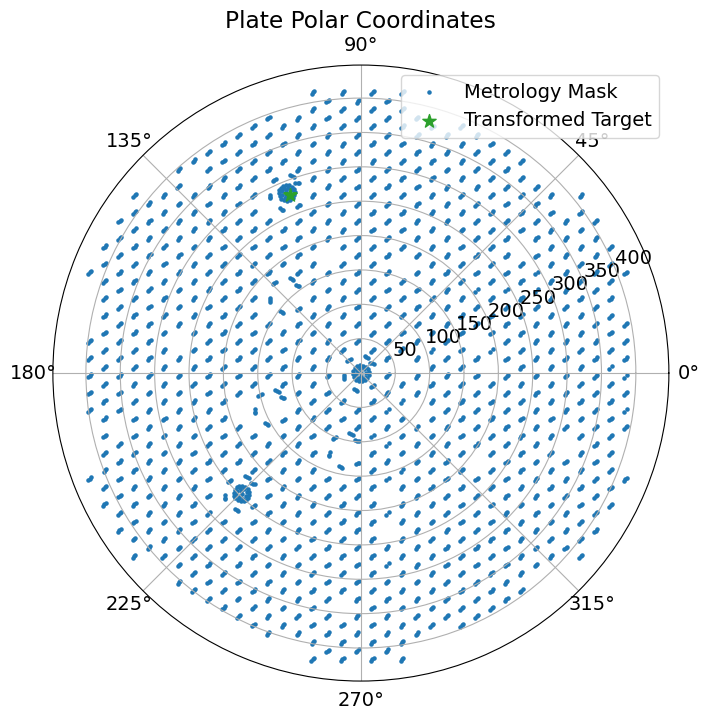

In [52]:
# plot the data in pixel coordinates
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(ac_data[:,0], ac_data[:,1])
ax.scatter(source_pos[:,0], source_pos[:,1], c='C2', marker='*', s=100)
ax.set_xlabel('X [pixels]')
ax.set_ylabel('Y [pixels]')
ax.set_title('Pixel Coordinates')
ax.grid()


# plot the data in cartesian plate coordinates
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(amdata[:,2], amdata[:,3], c='C0', label="Metrology Measurement", s=5)
ax.scatter(pix_in_plate[:, 1], pix_in_plate[:, 2], c='C1', marker='x', 
            label='Transformed Centroids', s=10)
ax.scatter(source_in_plate[0, 1], source_in_plate[0, 2], c='C2', marker='*', 
            label='Transformed Target', s=10)
ax.set_xlabel('Y [mm]')
ax.set_ylabel('Z [mm]')   
ax.set_aspect('equal')
ax.set_title('Plate Cartesian Coordinates')
ax.grid()
ax.legend()

# plot the data in cartesian plate coordinates
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(metmask1[:, 1], metmask1[:, 2], c='C0', label='Metrology Mask',
            s=100)
ax.scatter(pix_in_plate[:, 1], pix_in_plate[:, 2], c='C1', marker='x', 
            label='Transformed Centroids', s=100)
ax.scatter(source_in_plate[0, 1], source_in_plate[0, 2], c='C2', marker='*', 
            label='Transformed Target', s=100)
ax.set_xlabel('Y [mm]')
ax.set_ylabel('Z [mm]')   
ax.set_aspect('equal')
ax.set_title('Plate Cartesian Coordinates (Zoomed In)')
ax.grid()
ax.legend()


R_metmask, theta_metmask = convert_to_polar(metmask1[:,1], metmask1[:,2])
R_met, theta_met = convert_to_polar(amdata[:,2], amdata[:,3])
# plot the data in polar coordinates

fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': 'polar'})
ax.scatter(theta_met, R_met, c='C0', label='Metrology Mask', s=5)
ax.scatter(theta_source, R_source, c='C2', marker='*', 
            label='Transformed Target', s=100)
ax.set_title('Plate Polar Coordinates')
ax.legend()

plt.show()

During PAE testing, a nearby FPU was moved to the predicted source position in plate coordinates as a test of the transformation process. With the source still on, FPU 409 was moved to [R, Theta] = [278.3608 mm, 111.7833 deg] and the image was re-acquired to verify the accuracy of the transformation. The result was the following image:

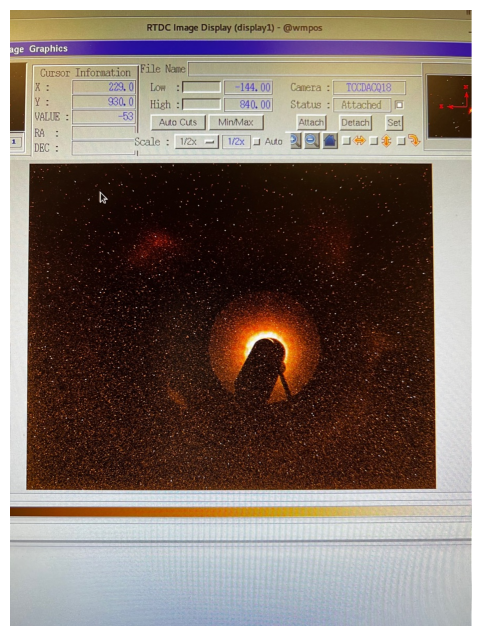

In [61]:
from PIL import Image

img = Image.open("../documentation/PAE_AC_testing.jpg")
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img)
ax.axis("off")
plt.show()

The image shows the FPU positioned at the predicted source position in plate coordinates. It is clearly obscuring the source showing that it is roughly aligned with the expected position. However, it is not exactly aligned with the centre of the source. This is likely due to the fact that FPU calibrations were not being correctly applied at the time of the test. This could cause positioning errors of up to ~0.5mm.

Further testing with correct offsets applied is required.